Dataset Shape: (569, 33)

First few rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_wors

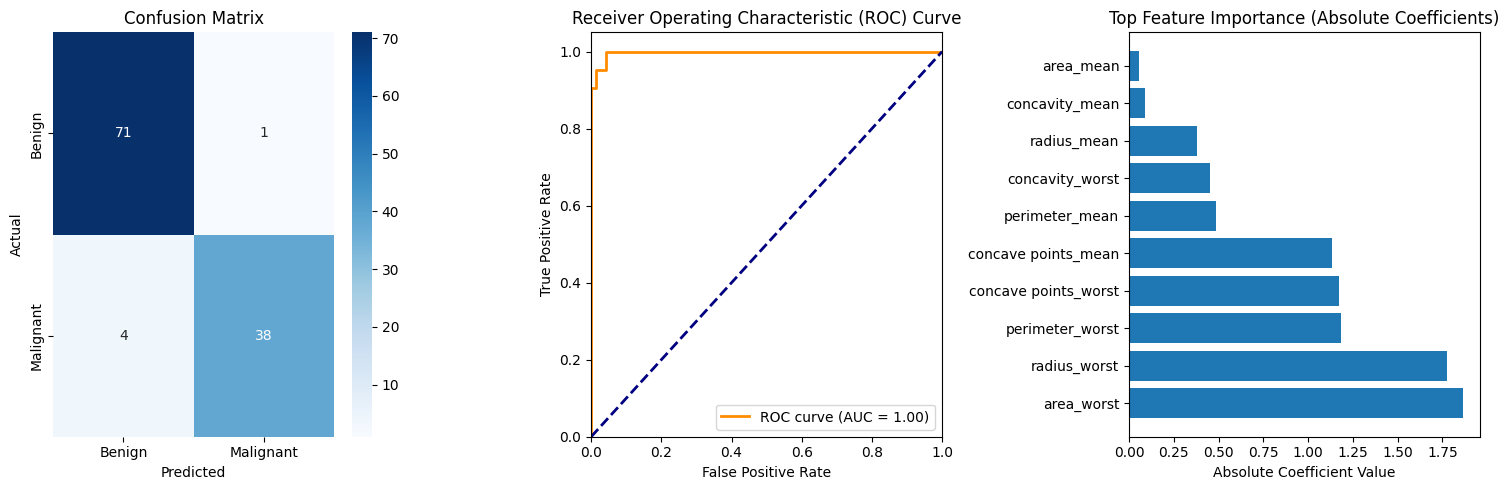


Model Coefficients:
area_worst: 1.8665 (+ - increases risk)
radius_worst: 1.7746 (+ - increases risk)
perimeter_worst: 1.1853 (+ - increases risk)
concave points_worst: 1.1735 (+ - increases risk)
concave points_mean: 1.1335 (+ - increases risk)
perimeter_mean: -0.4843 (- - decreases risk)
concavity_worst: 0.4497 (+ - increases risk)
radius_mean: -0.3801 (- - decreases risk)
concavity_mean: -0.0867 (- - decreases risk)
area_mean: 0.0535 (+ - increases risk)

Additional Metrics:
Precision: 0.9744
Recall: 0.9048
F1-Score: 0.9383

--- Cross-Validation Results ---
Cross-validation scores: [0.90350877 0.94736842 0.98245614 0.96491228 0.95575221]
Mean CV Accuracy: 0.9508 (+/- 0.0527)

=== Simple Approach: Drop All Missing Values ===
Dataset after dropping all missing values: (569, 30)
Selected 10 features: ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst', 'concave points_worst']
Simple 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('data.csv')

# Data Exploration
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())
print("\nTarget variable distribution:")
print(df['diagnosis'].value_counts())

# Convert target variable to binary (M=1, B=0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Check for missing values
print("\nMissing values:")
missing_values = df.isnull().sum()
print(missing_values)

# Show columns with missing values
columns_with_missing = missing_values[missing_values > 0]
print(f"\nColumns with missing values: {list(columns_with_missing.index)}")
print(f"Total missing values: {df.isnull().sum().sum()}")

# Handle missing values BEFORE creating the pipeline
print(f"\n=== Handling Missing Values ===")

# First, let's see if there are columns with all missing values
all_missing_cols = df.columns[df.isnull().all()].tolist()
if all_missing_cols:
    print(f"Columns with all values missing: {all_missing_cols}")
    df = df.drop(columns=all_missing_cols)
    print(f"Removed columns with all missing values. New shape: {df.shape}")

# Now handle remaining missing values by dropping rows with missing target
# and using a robust pipeline for feature missing values
if df['diagnosis'].isnull().any():
    print("Dropping rows with missing target variable...")
    df = df.dropna(subset=['diagnosis'])
    print(f"After dropping missing target: {df.shape}")

# Separate features and target
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for any remaining missing values in features
feature_missing = X.isnull().sum()
features_with_missing = feature_missing[feature_missing > 0]
print(f"Features with missing values: {list(features_with_missing.index)}")

# Create a custom transformer to handle feature selection with proper column names
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, score_func=f_classif, k=10):
        self.score_func = score_func
        self.k = k
        self.selector = SelectKBest(score_func=score_func, k=k)
        self.selected_features = None
        
    def fit(self, X, y=None):
        self.selector.fit(X, y)
        self.selected_features = self.selector.get_support()
        return self
        
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_feature_names(self, original_features):
        return original_features[self.selected_features]

# Create the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('feature_selector', FeatureSelector(score_func=f_classif, k=min(10, X.shape[1]))),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Fit the pipeline
print("Fitting pipeline...")
pipeline.fit(X_train, y_train)

# Get the selected features using our custom method
feature_selector = pipeline.named_steps['feature_selector']
selected_features = feature_selector.get_feature_names(X.columns)
print(f"\nSelected top {len(selected_features)} features: {list(selected_features)}")

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

# Get the classifier to access coefficients
classifier = pipeline.named_steps['classifier']

# Get feature importance
if hasattr(classifier, 'coef_'):
    coefficients = classifier.coef_[0]
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'coefficient': coefficients,
        'importance': np.abs(coefficients)
    }).sort_values('importance', ascending=False)
else:
    print("Classifier doesn't have coefficients attribute")
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': [1] * len(selected_features)  # Default importance
    })

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Feature Importance Plot
plt.subplot(1, 3, 3)
top_features = feature_importance.head(10)  # Show top 10 features
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Display model coefficients
print("\nModel Coefficients:")
for _, row in feature_importance.iterrows():
    sign = "+" if row['coefficient'] >= 0 else "-"
    interpretation = "increases risk" if row['coefficient'] > 0 else "decreases risk"
    print(f"{row['feature']}: {row['coefficient']:.4f} ({sign} - {interpretation})")

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Cross-validation with the pipeline
print("\n--- Cross-Validation Results ---")
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Alternative simpler approach: Drop all rows with any missing values
print("\n=== Simple Approach: Drop All Missing Values ===")
df_simple = df.dropna()
X_simple = df_simple.drop(['id', 'diagnosis'], axis=1)
y_simple = df_simple['diagnosis']

print(f"Dataset after dropping all missing values: {X_simple.shape}")

if len(X_simple) > 50:  # Only run if we have enough data
    # Simple feature selection
    k_simple = min(10, X_simple.shape[1])
    selector_simple = SelectKBest(score_func=f_classif, k=k_simple)
    X_simple_selected = selector_simple.fit_transform(X_simple, y_simple)
    selected_simple = X_simple.columns[selector_simple.get_support()]
    
    print(f"Selected {len(selected_simple)} features: {list(selected_simple)}")
    
    # Split
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_simple_selected, y_simple, test_size=0.2, random_state=42, stratify=y_simple
    )
    
    # Scale and train
    scaler_simple = StandardScaler()
    X_train_scaled_s = scaler_simple.fit_transform(X_train_s)
    X_test_scaled_s = scaler_simple.transform(X_test_s)
    
    log_reg_simple = LogisticRegression(random_state=42, max_iter=1000)
    log_reg_simple.fit(X_train_scaled_s, y_train_s)
    
    # Predict
    y_pred_s = log_reg_simple.predict(X_test_scaled_s)
    accuracy_s = accuracy_score(y_test_s, y_pred_s)
    print(f"Simple approach accuracy: {accuracy_s:.4f}")

# Display final dataset information
print(f"\n=== Dataset Summary ===")
print(f"Final dataset size: {df.shape}")
print(f"Missing values in final data: {df.isnull().sum().sum()}")
print(f"Features with missing values: {len(features_with_missing)}")
print(f"Benign cases (0): {len(y[y == 0])} ({len(y[y == 0])/len(y)*100:.1f}%)")
print(f"Malignant cases (1): {len(y[y == 1])} ({len(y[y == 1])/len(y)*100:.1f}%)")

# Show the top 5 most important features
print(f"\n=== Top 5 Most Important Features ===")
top_5_features = feature_importance.head(5)
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['coefficient']:.4f} (importance: {row['importance']:.4f})")

print("\n=== Analysis Complete ===")